## MuSCAT3/4 template

In [1]:
import sys

!{sys.executable} -m pip show prose

Name: prose
Version: 3.3.4
Summary: Modular image processing pipelines for Astronomy
Home-page: 
Author: Lionel Garcia
Author-email: 
License: MIT
Location: /mnt_ut2/raid_ut2/home/jerome/miniconda3/envs/prose/lib/python3.10/site-packages
Editable project location: /ut3/jerome/github/research/project/ext_tools/prose
Requires: astropy, astroquery, celerite2, imageio, ipython, matplotlib, multiprocess, numpy, pandas, photutils, pytest, pyyaml, requests, scikit-image, scipy, sep, tabulate, tqdm, twirl
Required-by: 


## dataset

In [3]:
import os
from glob import glob
from pathlib import Path

folder = Path("/data/MuSCAT4/250416/")

sciences = sorted(glob(str(folder / "*coj*.fits")))
sciences

['/data/MuSCAT4/250416/coj2m002-ep06-20250416-0058-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0059-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0060-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0061-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0062-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0063-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0064-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0065-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0066-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0067-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0068-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0069-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0070-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0071-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0072-e91.fits',
 '/data/MuSCAT4/250416/coj2m002-ep06-20250416-0073-e91.fits',
 '/data/

In [4]:
len(sciences)

4306

In [5]:
from prose import FITSImage

h = FITSImage(sciences[-1]).header
h['OBJECT']

'TOI-6715'

In [6]:
target_name = 'TOI-6715'

In [7]:
from astropy.io import fits
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

bands = "gp rp ip zs".split()
data = {b: [] for b in bands}

def process_file(fp):
    try:
        header = fits.getheader(fp, memmap=True)
        if header['OBJECT'] == target_name:
            band = header['FILTER1']
            if band in data:
                return band, fp
    except Exception as e:
        return None  # skip corrupted/missing headers
    return None

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_file, sciences), total=len(sciences)))

for result in results:
    if result:
        band, fp = result
        data[band].append(fp)

100%|███████████████████████████████████████| 4306/4306 [02:05<00:00, 34.40it/s]


In [7]:
# count
{b: len(data[b]) for b in bands}

{'gp': 495, 'rp': 1131, 'ip': 1130, 'zs': 1550}

## get target coords

In [20]:
from urllib.request import urlopen
import json

url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target_name.replace(' ','')}&json"
response = urlopen(url)
data_json = json.loads(response.read())
data_json['coordinates']

{'ra': '159.15796838828399',
 'dec': '-64.798230771542606',
 'galactic_long': '289.1993',
 'galactic_lat': '-5.584055',
 'ecliptic_long': '209.0367',
 'ecliptic_lat': '-62.9252',
 'pm_ra': '-17.5847',
 'pm_ra_error': '.03958',
 'pm_dec': '10.2991',
 'pm_dec_error': '.0355815'}

In [21]:
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec

(159.157968388284, -64.7982307715426)

## get header info

https://lco.global/observatory/instruments/muscat/#:~:text=MuSCAT3%20Release%20Notes%20Version%201.3,1.1%20from%20Jan%2029%202024

In [13]:
if (h['SITEID']=='coj') & (h['TELID']=='2m0a'):
    inst = 'MuSCAT4'
    saturation_limits = {
    'gp': 64000,
    'rp': 64000,
    'ip': 46000,
    'zs': 64000,
    }
elif (h['SITEID']=='ogg') & (h['TELID']=='2m0a'):
    inst = 'MuSCAT3'
    saturation_limits = {
    'gp': 120000/1.9,
    'rp': 120000/1.88,
    'ip': 82000/1.8,
    'zs': 100000/2.,
    }
else:
    raise ValueError("what data is this?")

## make ref image

In [14]:
from prose import Block
from prose.core.source import Sources
import numpy as np

class MaskSaturatedPixels(Block):
    def __init__(self, saturation_level=None, name=None):
        """Mask saturated pixels in the image.
        
        Parameters
        ----------
        saturation_level : float, optional
            The level above which a pixel is considered saturated.
            If None, will use image.saturation_level if available.
        name : str, optional
            Name of the block, by default None
        """
        super().__init__(name=name)
        self.saturation_level = saturation_level
        
    def run(self, image):
        # Determine saturation level
        sat_level = self.saturation_level
        if sat_level is None and hasattr(image, 'saturation_level'):
            sat_level = image.saturation_level
        
        if sat_level is None:
            raise ValueError("No saturation level provided or found in image")
        
        # Store original data
        if not hasattr(image, 'original_data'):
            image.original_data = image.data.copy()
        
        # Mask saturated pixels with NaN or median value
        mask = image.data >= sat_level
        if mask.any():
            # Option 1: Replace with NaN
            # image.data = image.data.copy()
            # image.data[mask] = np.nan
            
            # Option 2: Replace with median (might be better for detection algorithms)
            median_value = np.nanmedian(image.data)
            image.data = image.data.copy()
            image.data[mask] = median_value
            
class RejectSaturatedSources(Block):
    def __init__(self, saturation_level=None, name=None):
        """Filter out saturated sources from the detected sources.
        
        Parameters
        ----------
        saturation_level : float, optional
            The level above which a star is considered saturated.
            If None, will use image.saturation_level if available.
        name : str, optional
            Name of the block, by default None
        """
        super().__init__(name=name)
        self.saturation_level = saturation_level
        
    def run(self, image):
        if len(image.sources) == 0:
            return
            
        # Determine saturation level
        sat_level = self.saturation_level
        if sat_level is None and hasattr(image, 'saturation_level'):
            sat_level = image.saturation_level
        
        if sat_level is None:
            raise ValueError("No saturation level provided or found in image")
            
        # Filter out sources with peak values above saturation level
        non_saturated = [s for s in image.sources if s.peak < sat_level]
        image.sources = Sources(non_saturated, type=image.sources.type)

In [32]:
from prose import Telescope

b = 'rp'
ndata = len(data[b])
saturation = saturation_limits[b]
telescope = Telescope(saturation=saturation)
ref_file = data[b][ndata//2]
ref = FITSImage(ref_file, telescope=telescope)

In [33]:
ref.__dict__.keys()

dict_keys(['data', 'metadata', 'catalogs', '_sources', 'origin', 'discard', 'computed', 'header', '_wcs'])

In [34]:
from prose import Sequence, blocks

nstars = 10
cutout_shape = 35
saturation = saturation_limits[band]
calibration = Sequence(
        [
            blocks.Trim((0,0), skip_wcs=True),
            # MaskSaturatedPixels(saturation),
            blocks.PointSourceDetection(n=nstars, min_area=20,
                                        threshold=10, min_separation=0
                                       ),  # stars detection
            # RejectSaturatedSources(saturation),
            blocks.Cutouts(shape=cutout_shape),  # stars cutouts
            blocks.MedianEPSF(),  # building EPSF
            blocks.psf.Moffat2D(),  # modeling EPSF
            blocks.CentroidQuadratic(),  # centroiding
            blocks.AperturePhotometry(),  # aperture photometry
            blocks.AnnulusBackground(),  # annulus background
        ]
    )

calibration.run(ref, show_progress=False)

## plot ref image

Text(0.5, 1.0, 'rp-band')

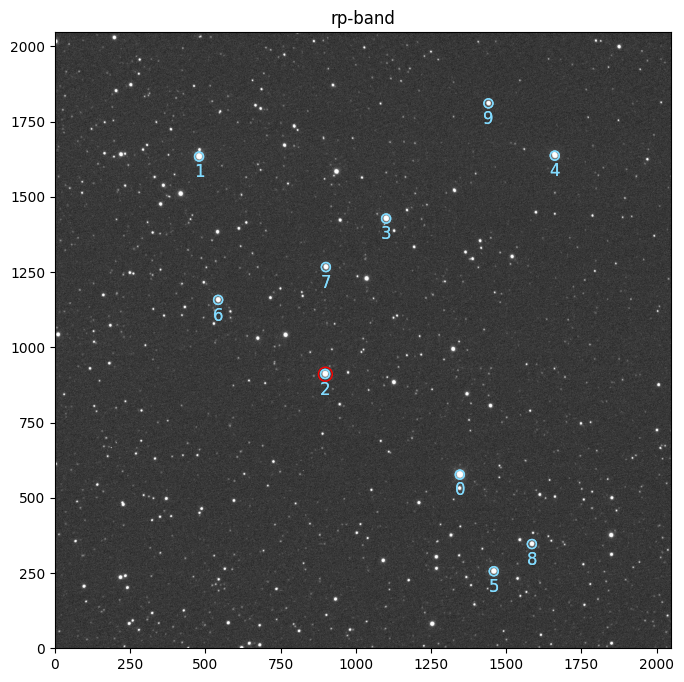

In [35]:
import matplotlib.pyplot as pl
from astropy.wcs import WCS

wcs = WCS(ref.header)
ref.show()
ra_pix, dec_pix = wcs.wcs_world2pix([[ra,dec]], 0)[0]
pl.scatter(ra_pix, dec_pix, s=100, ec='r', fc='none')
ref.sources.plot(color='y')
pl.title(f"{ref.header['FILTER']}-band")

In [36]:
ref.__dict__.keys()

dict_keys(['data', 'metadata', 'catalogs', '_sources', 'origin', 'discard', 'computed', 'header', '_wcs'])

In [37]:
len(ref.computed['cutouts'])

10

## check detected reference stars

Text(0.5, 0.98, 'rp-band')

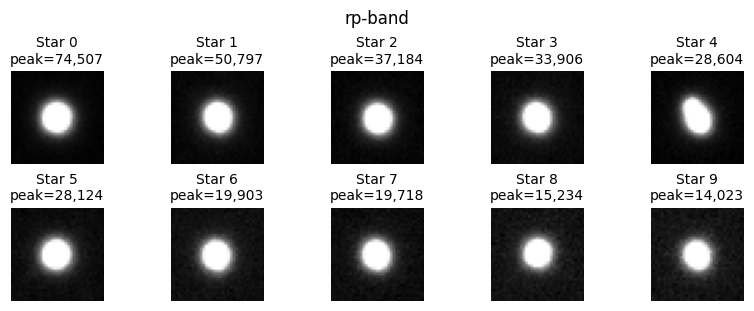

In [39]:
import matplotlib.pyplot as pl

ncutouts = len(ref.computed['cutouts'])
nrows = 2
fig, axs = pl.subplots(nrows, ncutouts//nrows, figsize=(8,3), constrained_layout=True)
ax = axs.flatten()
for i,img in enumerate(ref.computed['cutouts']):
    img.show(ax=ax[i])
    peak = ref._sources[i].peak
    ax[i].set_title(f"Star {i}\npeak={peak:,.0f}", fontsize=10)
    ax[i].axis("off")
fig.suptitle(f"{b}-band")

In [18]:
ref.computed.keys()

dict_keys(['telescope', 'i', 'cutouts', 'epsf', 'epsf_n_sources', 'fwhm', 'aperture', 'annulus'])

In [19]:
ref.aperture.keys()

dict_keys(['fluxes', 'radii'])

In [20]:
ref.aperture['radii']

array([  0.8503451 ,   1.00297733,   1.18300621,   1.39534927,
         1.64580673,   1.94121992,   2.28965813,   2.70063908,
         3.18538883,   3.75714848,   4.43153581,   5.22697194,
         6.16518444,   7.27180088,   8.57704885,  10.11658159,
        11.93245193,  14.07426094,  16.60051279,  19.58021286,
        23.09475257,  27.2401327 ,  32.12958558,  37.89666816,
        44.69891012,  52.72211681,  62.18544465,  73.34738739,
        86.51283702, 102.0414119 ])

## plot nearby stars

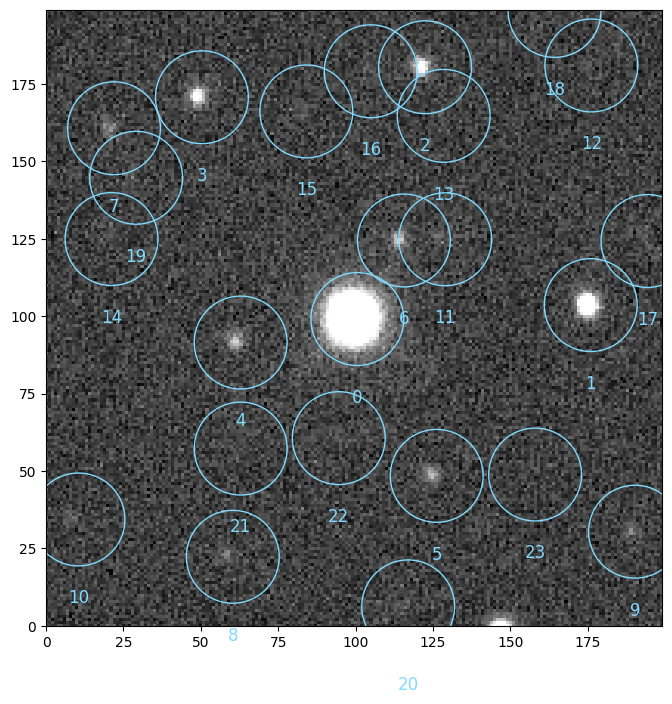

In [21]:
from prose.blocks import catalogs
import astropy.units as u

tid = 2 #target id
# c = ref.computed['cutouts'][tid] #orig cutout too small
c = ref.cutout(ref.sources[tid].coords, (200, 200)) #make a larger cutout to see nearby Gaia sources

c.fov = c.shape*ref.header['pixscale']*u.arcsec #need to add fov attribute before querying Gaia
c = catalogs.GaiaCatalog(mode="replace")(c)
# mode="crossmatch" to match existing Image.sources 
# mode="replace" to use queried stars as Image.sources
c.show()

In [22]:
c.catalogs['gaia'].head()

,index,solution_id,id,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,x,y
0,0,1635721458409799680,Gaia DR2 5239758155778687360,5239758155778687360,1183713357,2015.5,159.157855,0.019823,-64.798203,0.020017,...,0.703076,0.650527,0.741889,0.232342,0.230896,0.233788,https://gea.esac.esa.int/data-server/datalink/...,,100.537193,99.082723
1,2,1635721458409799680,Gaia DR2 5239758228822514816,5239758228822514816,35320498,2015.5,159.144705,0.040808,-64.797866,0.040114,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,175.935513,103.596007
2,4,1635721458409799680,Gaia DR2 5239758331901747584,5239758331901747584,1021168950,2015.5,159.154040,0.070831,-64.792161,0.065796,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,122.422254,180.426762
3,5,1635721458409799680,Gaia DR2 5239758258859683712,5239758258859683712,896744102,2015.5,159.166609,0.075696,-64.792881,0.068765,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,50.337848,170.733745
4,7,1635721458409799680,Gaia DR2 5239758258861086080,5239758258861086080,525500006,2015.5,159.164428,0.106584,-64.798766,0.104074,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,62.850006,91.492999


## determine nearest star

In [23]:
df = c.catalogs['gaia'].copy()
df.head()

,index,solution_id,id,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,x,y
0,0,1635721458409799680,Gaia DR2 5239758155778687360,5239758155778687360,1183713357,2015.5,159.157855,0.019823,-64.798203,0.020017,...,0.703076,0.650527,0.741889,0.232342,0.230896,0.233788,https://gea.esac.esa.int/data-server/datalink/...,,100.537193,99.082723
1,2,1635721458409799680,Gaia DR2 5239758228822514816,5239758228822514816,35320498,2015.5,159.144705,0.040808,-64.797866,0.040114,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,175.935513,103.596007
2,4,1635721458409799680,Gaia DR2 5239758331901747584,5239758331901747584,1021168950,2015.5,159.154040,0.070831,-64.792161,0.065796,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,122.422254,180.426762
3,5,1635721458409799680,Gaia DR2 5239758258859683712,5239758258859683712,896744102,2015.5,159.166609,0.075696,-64.792881,0.068765,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,50.337848,170.733745
4,7,1635721458409799680,Gaia DR2 5239758258861086080,5239758258861086080,525500006,2015.5,159.164428,0.106584,-64.798766,0.104074,...,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,62.850006,91.492999


In [24]:
from astropy.coordinates import SkyCoord

target_coord = SkyCoord(ra, dec, unit='deg')
gaia_coords = SkyCoord(df.ra, df.dec, unit='deg')

In [25]:
df['sep_arcsec'] = target_coord.separation(gaia_coords).arcsec
df['sep_pix'] = (df['sep_arcsec']/ref.header['PIXSCALE']).round() #pixel
df = df.sort_values(by='sep_arcsec').reset_index(drop=True)
df.sep_pix.head()

0     1.0
1    30.0
2    38.0
3    39.0
4    39.0
Name: sep_pix, dtype: float64

In [26]:
#nearest star
aper_rad_max_pix = df.iloc[1].sep_pix
aper_rad_max_pix

30.0

In [27]:
aper_rad_min_pix = round(ref.fwhm)
aper_rad_min_pix

9

In [28]:
assert aper_rad_min_pix<aper_rad_max_pix

In [29]:
default_radii = ref.aperture['radii']
len(default_radii)

30

In [30]:
import numpy as np

# the default aperture radii in blocks.AperturePhotometry() is scaled by fwhm like so:
np.exp(np.linspace(np.log(0.1), np.log(12), 30))*ref.fwhm

array([  0.8503451 ,   1.00297733,   1.18300621,   1.39534927,
         1.64580673,   1.94121992,   2.28965813,   2.70063908,
         3.18538883,   3.75714848,   4.43153581,   5.22697194,
         6.16518444,   7.27180088,   8.57704885,  10.11658159,
        11.93245193,  14.07426094,  16.60051279,  19.58021286,
        23.09475257,  27.2401327 ,  32.12958558,  37.89666816,
        44.69891012,  52.72211681,  62.18544465,  73.34738739,
        86.51283702, 102.0414119 ])

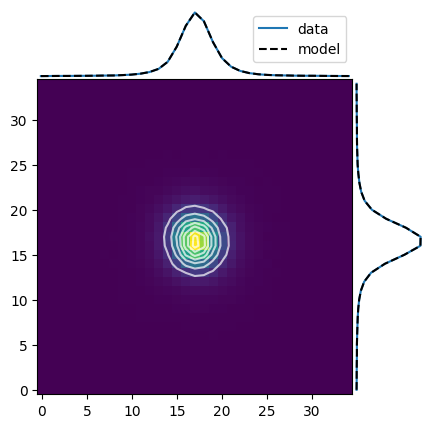

In [31]:
# how's the FWHM like?
c = ref.computed['cutouts'][tid]
c.plot_model(c.data, contour=True)

## set aperture radii and background annulus (pix)

In [32]:
aper_radii = np.arange(aper_rad_min_pix, aper_rad_max_pix, 2)
aper_radii

array([ 9., 11., 13., 15., 17., 19., 21., 23., 25., 27., 29.])

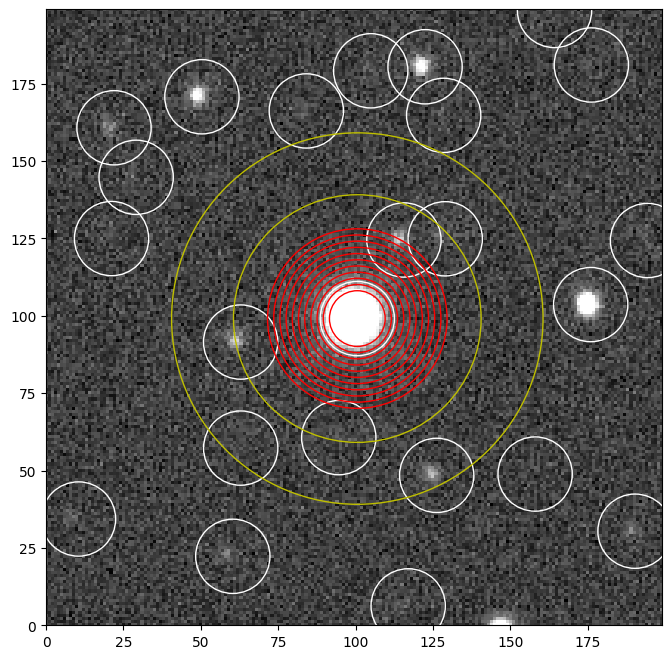

In [33]:
import numpy as np

c = ref.cutout(ref.sources[tid].coords, (200, 200))
c.show(zscale=True, sources=False)

c.fov = c.shape*ref.header['pixscale']*u.arcsec #need to add fov attribute before querying Gaia
c = catalogs.GaiaCatalog(mode="replace")(c)
c.plot_catalog("gaia", label=False, color="w")

# aperture radii
for r in aper_radii: 
    c.sources[0].plot(r, label=False, c="r")
    
# background annulus
dr = 20
rin = aper_rad_max_pix+10
rout = rin+dr #in units of fwhm
c.sources[0].plot(rin, label=False, c="y")
c.sources[0].plot(rout, label=False, c="y")

## check PSF model

Text(0.5, 1.0, 'diff')

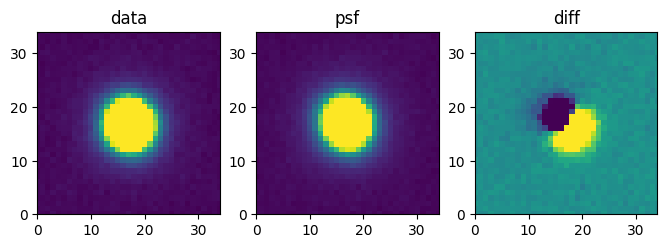

In [34]:
import matplotlib.pyplot as pl
from prose import Image

cmap='viridis'

fig, axs = pl.subplots(1,3, figsize=(8,3))
ax = axs.flatten()

c=ref.computed['cutouts'][tid]
c.show(ax=ax[0], cmap=cmap)
ax[0].set_title('data')
epsf=ref.computed['epsf']
epsf.show(ax=ax[1], cmap=cmap)

# params = epsf.params
# model = Image(epsf.model(params))
# model.show(ax=ax[1], cmap=cmap)
ax[1].set_title('psf')
d = Image(c.data/c.data.max()-epsf.data)
d.show(ax=ax[2], cmap=cmap)
ax[2].set_title('diff')

## reduction

In [35]:
import numpy as np
from prose import FITSImage, Sequence, blocks
from prose.core.sequence import SequenceParallel

nstars = 10
cutout_shape = 31
scale_radii_to_fwhm = False 

def run_phot(data, ref, saturation=None):
    
    calibration = Sequence(
        [
            blocks.Trim(),
            blocks.PointSourceDetection(n=nstars, min_area=20, min_separation=100),  # stars detection
            RejectSaturatedSources(saturation),
            blocks.Cutouts(shape=cutout_shape),  # stars cutouts
            blocks.MedianEPSF(),  # building EPSF
            blocks.psf.Moffat2D(),  # modeling EPSF
        ]
    )
    
    calibration.run(ref, show_progress=False)
    
    phot = SequenceParallel(
        blocks=[
                calibration[0],  # trim from calibration block (same as above)
                blocks.PointSourceDetection(n=nstars, min_area=20, min_separation=100),  # fewer stars detection
                RejectSaturatedSources(saturation),
                blocks.Cutouts(shape=cutout_shape),  # stars cutouts
                blocks.MedianEPSF(),  # building EPSF
                blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
                blocks.ComputeTransformTwirl(ref, n=nstars),  # compute alignment
                blocks.AlignReferenceSources(ref),  # alignment
                blocks.CentroidQuadratic(),  # centroiding
                blocks.AperturePhotometry(aper_radii, scale=scale_radii_to_fwhm),  # aperture photometry
                blocks.AnnulusBackground(rin=rin, rout=rout, scale=scale_radii_to_fwhm),  # annulus background
                ],
        data_blocks=[
                blocks.GetFluxes(
                    "fwhm",
                    airmass=lambda im: im.header["AIRMASS"],
                    dx=lambda im: im.transform.translation[0],
                    dy=lambda im: im.transform.translation[1],
                    peak=lambda im: np.nanmax(im.data)
                ),
            ],
        )
        
    phot.run(data)
    
    return dict(phot=phot, ref=ref)

phot = {}
for band in bands:
    saturation = saturation_limits[band]
    phot[band] = run_phot(data[band], ref, saturation)

100%|███████████████████████████████████| 1550/1550 [05:56<00:00,  4.34images/s]


## photometry data

In [36]:
phot[band]['phot']

╒═════════╤════════╤═══════════════════════╤════════════════╕
│   index │ name   │ type                  │ processing     │
╞═════════╪════════╪═══════════════════════╪════════════════╡
│       0 │        │ Trim                  │ 0.009 s (100%) │
├─────────┼────────┼───────────────────────┼────────────────┤
│       1 │        │ PointSourceDetection  │ 0.000 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       2 │        │ Cutouts               │ 0.000 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       3 │        │ MedianEPSF            │ 0.000 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       4 │        │ Gaussian2D            │ 0.000 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       5 │        │ ComputeTransformTwirl │ 0.000 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       6 │        │ AlignReferenceSources │ 0.000 s (0%)   │
├───────

In [37]:
phot[band]['phot'].__dict__.keys()

dict_keys(['name', 'images', 'blocks_dict', 'data', 'n_processed_images', 'last_image', 'buffer', '_has_data', 'progress', 'discards'])

In [51]:
phot[band]['phot'].data[0].__dict__.keys()

dict_keys(['_time_key', '__doc__', 'name', 'unit_data', 'processing_time', 'runs', 'in_sequence', 'verbose', '_data_block', 'size', 'read', 'getters', 'values', 'arrays', '_parallel_friendly', 'fluxes'])

## reference frames

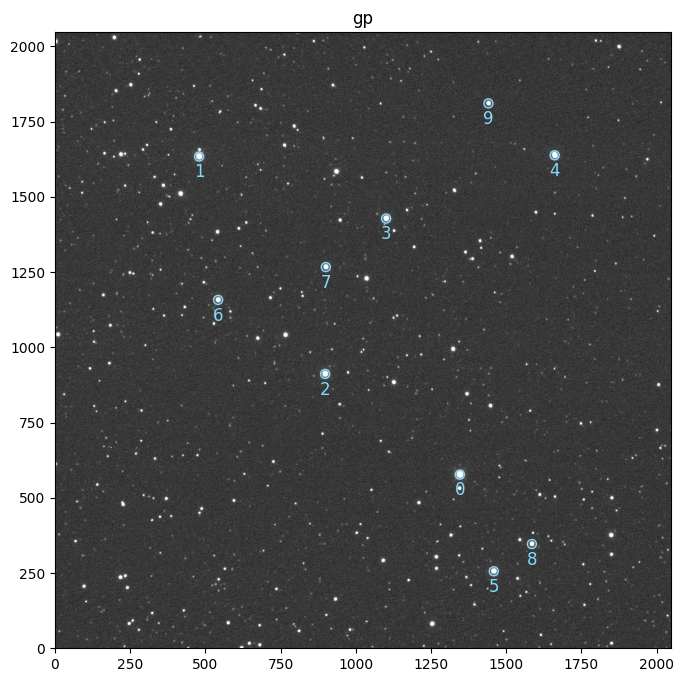

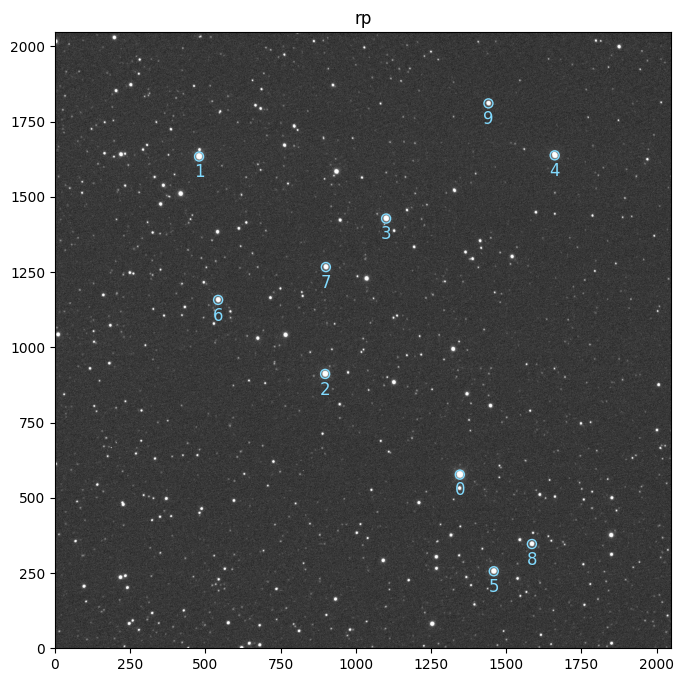

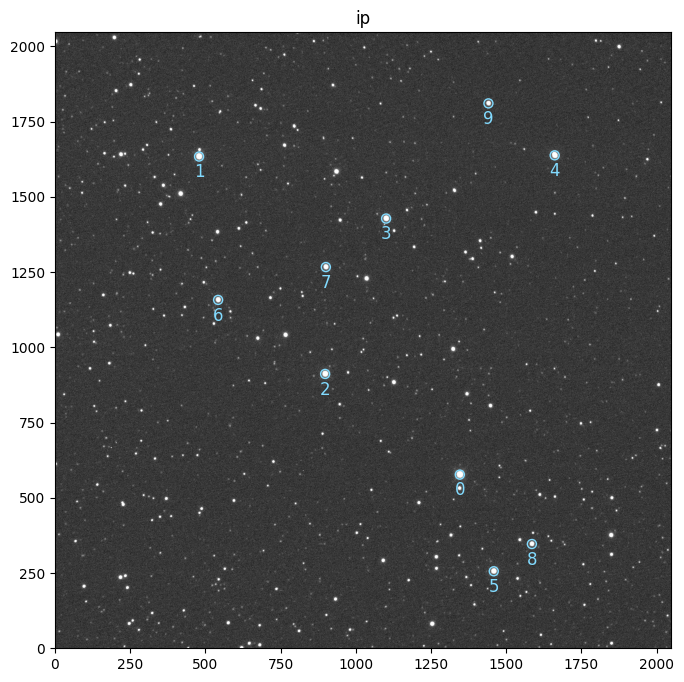

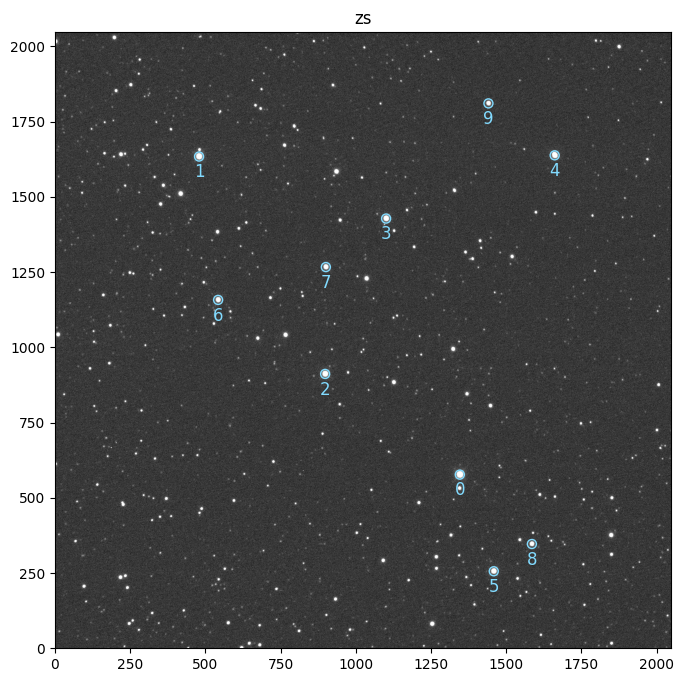

In [38]:
from prose import Fluxes
import matplotlib.pyplot as plt

for band in bands:
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    phot[band]['ref'].show()
    plt.title(band)

In [39]:
fluxes.__dict__.keys()

dict_keys(['fluxes', 'time', 'errors', 'data', 'apertures', 'weights', 'target', 'aperture', 'metadata'])

In [40]:
fluxes.target = tid
aper_idx = fluxes.best_aperture_index()
aper_idx

9

In [41]:
fluxes.shape #aper, nstars, ndata

(11, 10, 1550)

## absolute photometry

## differential photometry

In [54]:
import matplotlib.pyplot as plt

def get_diff_phot(fluxes, target, plot=True, color='k', ax=None):
    
    fluxes.target = target
    
    # a bit of cleaning
    nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
    fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
    fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping
    
    # differential photometry
    diff = fluxes.autodiff()
    
    if plot:
        # plotting
        bin = diff.bin(10 / 60 / 24, estimate_error=True)            
        ax.errorbar(bin.time, bin.flux, bin.error, c=color, ls='', marker='o')
        diff.plot(ax=ax)
        if True:
            # show ingress, midpoint, egress
            ax.axvline(ing0[0], 0, 1, ls='--', c='k')
            ax.axvline(mid0[0], 0, 1, ls='-', c='k')
            ax.axvline(egr0[0], 0, 1, ls='--', c='k')
    return diff

In [ ]:
diffs = {}
tids = [tid]*len(bands)
fig, axs = plt.subplots(len(bands), 1, figsize=(10, 8), sharex=True)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=True, color=f'C{i}', ax=axs[i])
    diffs[band] = diff
    axs[i].set_title(band)

fig.tight_layout()

In [ ]:
diff.data.keys()

## GJD_UTC to BJD_TDB conversion

In [139]:
from astroplan import Observer
from astropy.time import Time

lco_sites = {
    #LCO-1m
    "LCOGT node at Tenerife": "teide",
    "LCOGT node at McDonald Observatory": "McDonald",
    "LCOGT node at Cerro Tololo Inter-American Observatory": "cerro tololo interamerican observatory",
    #LCO-2m
    "LCOGT node at Haleakala Observatory" : "Haleakala",
    "LCOGT node at Siding Spring Observatory": "Siding Spring Observatory",    
    }
lco_codes = {
    #lco observatory site codes
    "LCOGT node at Siding Spring Observatory": "coj",
    "LCOGT node at Haleakala Observatory" : "ogg",
    "LCOGT node at Cerro Tololo Inter-American Observatory": 'lsc',
    "LCOGT node at Tenerife": 'tfn',
    "LCOGT node at SAAO": 'cpt',
}

site = ref.header['site']
obs_site = Observer.at_site(lco_sites[site])
obj_coord = SkyCoord(ra=ra, dec=dec, unit=("deg","deg"))

use_barycorrpy = False

bjds = {}
for band in bands:
    gjd = diffs[band].time
    t = Time(gjd, format='jd', scale='utc', location=obs_site.location)

    if use_barycorrpy:
        #https://arxiv.org/pdf/1801.01634.pdf
        try:
            from barycorrpy import utc_tdb
        except:
            raise ImportError("pip install barycorrpy")
        #convert jd to bjd_tdb
        result = utc_tdb.JDUTC_to_BJDTDB(t.value, 
                                         ra=obj_coord.ra.deg, 
                                         dec=obj_coord.dec.deg, 
                                         lat=obs_site.location.lat.deg, 
                                         longi=obs_site.location.lon.deg, 
                                         alt=obs_site.location.height.value)
        bjds[band] = result[0]
        offset = result[0]-t.value        
    else:
        #BJD time format in TDB time scale
        #see MuSCAT2_transit_pipeline/muscat2ph/phdata.py l218
        lttd = t.light_travel_time(obj_coord, kind='barycentric')
        bjd_tdb = t.tdb + lttd
        bjds[band] = bjd_tdb
        offset = bjd_tdb.value - t.jd
        #check difference between two time scales (should be < 8 mins!)
    offset_in_minutes = np.median(offset)*24*60
    msg = f"computed GJD-TDB offset={offset_in_minutes:.3} min"
    assert offset_in_minutes<=2*8.3, errmsg+" > 2*8.4 min!"
print(msg)

computed GJD-TDB offset=4.97 min


## export photometry into csv

In [140]:
import pandas as pd

save_csv = True
outdir = "."
date = ref.header['DAY-OBS'][2:]

for band,diff in diffs.items():
    df = diff.df.copy()
    df['BJD_TDB'] = bjds[band]
    df['Flux_Err'] = diff.error
    # rename columns
    df = df.rename({'time': 'GJD_UTC',
                    'flux': 'Flux',
                    'airmass': 'Airmass',
                    'dx': 'Dx(pix)',
                    'dy': 'Dy(pix)',
                    'bkg': 'Bkg(ADU)',
                    'fwhm': 'FWHM(pix)',
                    'peak': 'Peak(ADU)'
                   }, axis=1)
    print(df.head())
    if save_csv:
        fp = f"{outdir}/{target_name.replace(' ', '')}_{date}_{inst.lower()}_{lco_codes[site]}_{band[0]}_prose.csv"
        df.to_csv(fp, index=False)
        print("Saved: ", fp) 

Saved:  ./toi-6715_250416_muscat4_gp_prose.csv
Saved:  ./toi-6715_250416_muscat4_rp_prose.csv
Saved:  ./toi-6715_250416_muscat4_ip_prose.csv
Saved:  ./toi-6715_250416_muscat4_zs_prose.csv


## plots

Text(0.5, 0.98, 'TOI-6715 | MuSCAT4 | 250416')

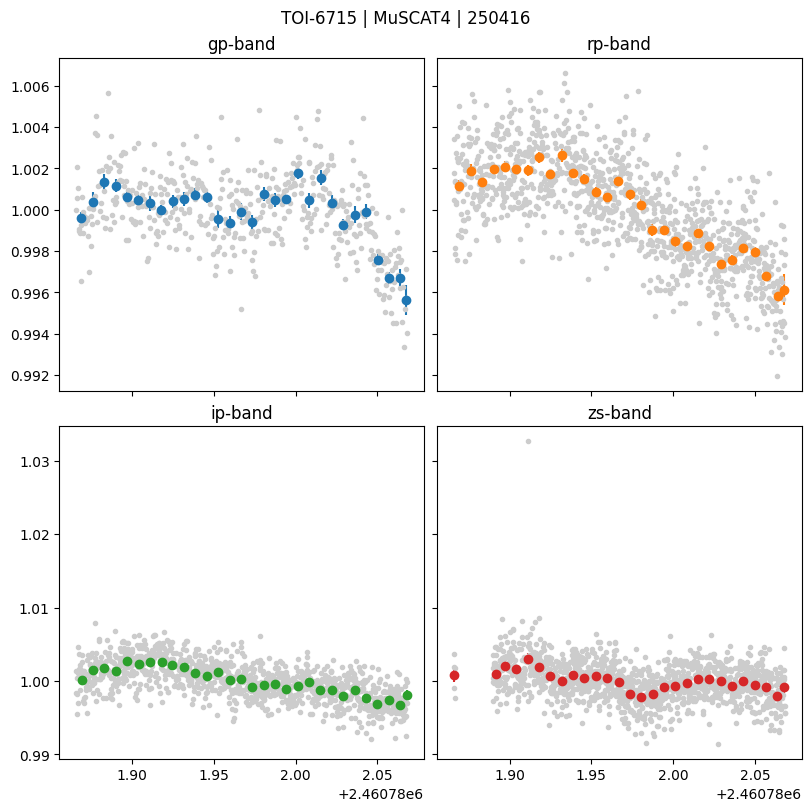

In [47]:
import pandas as pd

tid = 2
fig, axs = pl.subplots(2, 2, figsize=(8,8), sharex='col', sharey='row', constrained_layout=True)
ax = axs.flatten()
for i,band in enumerate(bands):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
    fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
    fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping
    diff = get_diff_phot(fluxes, tid, plot=True, color=f'C{i}', ax=ax[i])
    ax[i].set_title(f"{band}-band")
fig.suptitle(f"{target_name} | {inst} | {date}")

And here is our planetary transit. To validate the differential photometry and the automatic choice of comparison stars, we can plot their light curves along the target light curve

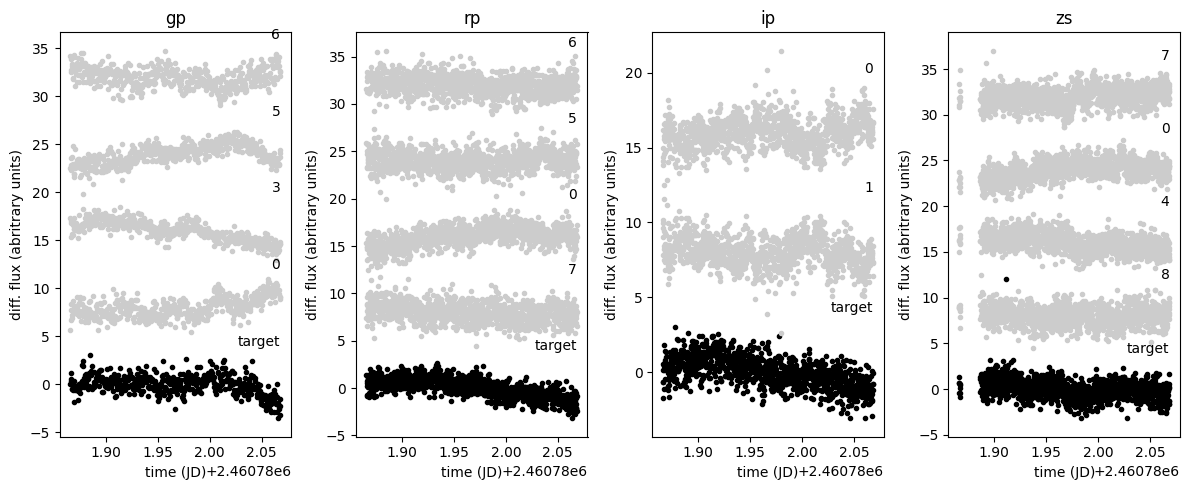

In [72]:
def plot_comp(diff, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))
    
    # plotting only the first five comparisons
    for j, i in enumerate([diff.target, *diff.comparisons[0:5]]):
        y = diff.fluxes[diff.aperture, i].copy()
        y = (y - np.mean(y)) / np.std(y) + 8 * j
        ax.text(
            diff.time.max(), np.mean(y) + 4, i if i != diff.target else "target", ha="right"
        )
        ax.plot(diff.time, y, ".", c="0.8" if i != diff.target else "k")

    plt.setp(ax, xlabel="time (JD)", ylabel="diff. flux (abritrary units)")
    
fig, axs = plt.subplots(1, len(bands), figsize=(3*len(bands), 5), sharex=True, sharey=False)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=False)
    plot_comp(diff, ax=axs[i])
    axs[i].set_title(band)

fig.tight_layout()

# Explanatory measurements

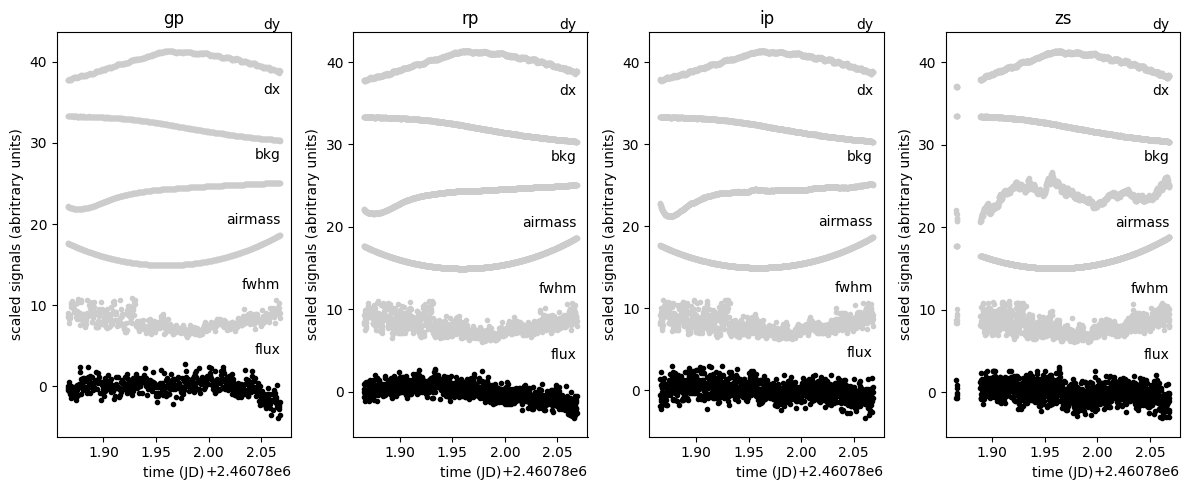

In [283]:
def plot_aux(diff, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))
    
    for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy"]):
        y = diff.df[name].copy()
        y = (y - np.mean(y)) / np.std(y) + 8 * i
        ax.text(diff.time.max(), np.mean(y) + 4, name, ha="right")
        ax.plot(diff.time, y, ".", c="0.8" if name != "flux" else "k")

    plt.setp(ax, xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

fig, axs = plt.subplots(1, len(bands), figsize=(3*len(bands), 5), sharex=True, sharey=False)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=False)
    plot_aux(diff, ax=axs[i])
    axs[i].set_title(band)
    
fig.tight_layout()

## quick look plots

In [ ]:
import sys
sys.path.insert(0, "/ut3/muscat/github/tfop_code/")

In [ ]:
import pandas as pd

target_name = 'TOI6715'
date = 250523
instrument = 'muscat4'
site = 'coj'
pipeline = 'prose'

data = {}
for b in bands:
    data[b] = pd.read_csv(f'./{target_name}_{date}_{instrument}_{site}_{b}_{pipeline}.csv')

In [ ]:
from tfop_analysis import plot_ql, colors
from aesthetic.plot import savefig

exptimes = {'g': 20, 'r': 20, 'i': 20, 'z': 20}
for i,b in enumerate(data):
    fig = plot_ql(data[b],
                  title=f'{target_name}.01 | LCO-1m/{instrument} | {date} | {b}=band',
                  exptime=exptimes[b],
                  mcolor=colors[b],
                  binsize=10/60/24,
                  figsize=(10,10),
                  font_size=16,
                  title_height=0.93
                 )
    if False:
        outfile = f"{outdir}/{target}b_{date}_{inst}_{b}_ql.pdf"
        fig.savefig(outfile, dpi=300)